# scRNA embedding and NN search

- Evaluate NN efficacy after embedding within and across disjoint datasets

## Evaluation metrics

1. Pairwise distance loss
- Let $X_{test} \cap X_{train}=\emptyset$. Guarantees no leak if embedding method is fit to train.
- $L = cossim(x_i, x_j) - cossim(x_i', x_j'): x_i,x_j \in X_{test} \land x_i,x_j \notin X_{train}$; $x_i', x_j'$ are embeddings, $x_i, x_j$ are original encodings
- Aggregate with $MSE$

2. Recall at top k

2. Across dataset NN recall
- Input: 2 different scRNA cell x gene datasets
- Ground truth: top $k$ NN for each sample. Neighbor search includes both datasets
- Predicted: top $k$ NN for each sample after dim reduction
- Loss: NN recall in embedding space
- Permutations: 1) Embed within a dataset (local) and 2) across dataset embedding (global)


In [65]:

import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import math
from datasketch import MinHash, MinHashLSH
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import itertools
import time
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random
from matplotlib.colors import ListedColormap
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import torch.nn.functional as F
import json
import datetime
from sklearn.random_projection import johnson_lindenstrauss_min_dim
plt.rcParams.update({'font.size': 15})
import umap.umap_ as umap

cpu


## Data

Human blood scRNA cell by gene: https://cellxgene.cziscience.com/datasets

Publication: https://www.biorxiv.org/content/10.1101/2024.06.18.599579v1.full

In [2]:
path = 'data/Fluent-rep1.h5ad'
adata = sc.read_h5ad(path)
metadata = adata.obs

df = adata.to_df()

In [3]:
print(df.shape)
print(df.head())

(7750, 29898)
Ensemble_ID                   ENSG00000243485  ENSG00000238009  \
AGGCATAGCAGCATTA_Fluent-rep1        -0.031458         4.307281   
AACTAGCACAAACAAC_Fluent-rep1        -0.031458        -0.125545   
AAAAAGCGCCCGATTA_Fluent-rep1        -0.031458        -0.125545   
ATGTATAGAAAGCAGA_Fluent-rep1        -0.031458        -0.125545   
CCCCATGGACACAAGT_Fluent-rep1        -0.031458        -0.125545   

Ensemble_ID                   ENSG00000239945  ENSG00000241860  \
AGGCATAGCAGCATTA_Fluent-rep1        21.851351        -0.177241   
AACTAGCACAAACAAC_Fluent-rep1        -0.031319        -0.177241   
AAAAAGCGCCCGATTA_Fluent-rep1        -0.031319        -0.177241   
ATGTATAGAAAGCAGA_Fluent-rep1        -0.031319        -0.177241   
CCCCATGGACACAAGT_Fluent-rep1        -0.031319        -0.177241   

Ensemble_ID                   ENSG00000286448  ENSG00000236601  \
AGGCATAGCAGCATTA_Fluent-rep1        -0.015653        -0.044056   
AACTAGCACAAACAAC_Fluent-rep1        -0.015653        -0.0440

In [4]:
print(metadata.shape)
print(metadata.head())

(7750, 23)
                                      kit organism_ontology_term_id  \
AGGCATAGCAGCATTA_Fluent-rep1  Fluent-rep1            NCBITaxon:9606   
AACTAGCACAAACAAC_Fluent-rep1  Fluent-rep1            NCBITaxon:9606   
AAAAAGCGCCCGATTA_Fluent-rep1  Fluent-rep1            NCBITaxon:9606   
ATGTATAGAAAGCAGA_Fluent-rep1  Fluent-rep1            NCBITaxon:9606   
CCCCATGGACACAAGT_Fluent-rep1  Fluent-rep1            NCBITaxon:9606   

                             tissue_ontology_term_id tissue_type  \
AGGCATAGCAGCATTA_Fluent-rep1          UBERON:0000178      tissue   
AACTAGCACAAACAAC_Fluent-rep1          UBERON:0000178      tissue   
AAAAAGCGCCCGATTA_Fluent-rep1          UBERON:0000178      tissue   
ATGTATAGAAAGCAGA_Fluent-rep1          UBERON:0000178      tissue   
CCCCATGGACACAAGT_Fluent-rep1          UBERON:0000178      tissue   

                             assay_ontology_term_id disease_ontology_term_id  \
AGGCATAGCAGCATTA_Fluent-rep1            EFO:0008913             PATO:0000

In [5]:
adata.obsm

AxisArrays with keys: X_pca, X_umap

In [6]:
adata.obsm['X_pca'].shape

(7750, 50)

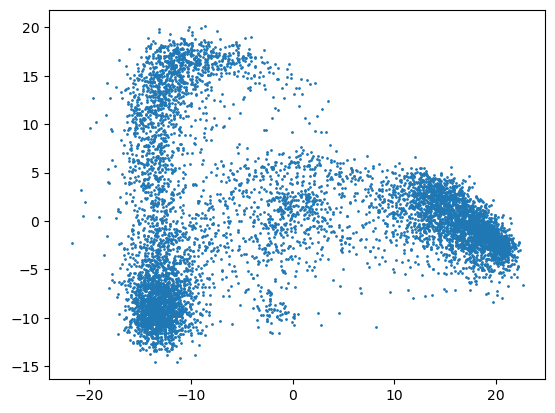

In [7]:
# plot first 2 PCs
x = adata.obsm['X_pca'][:,0]
y = adata.obsm['X_pca'][:,1]
# small dots
plt.scatter(x,y, s=1)

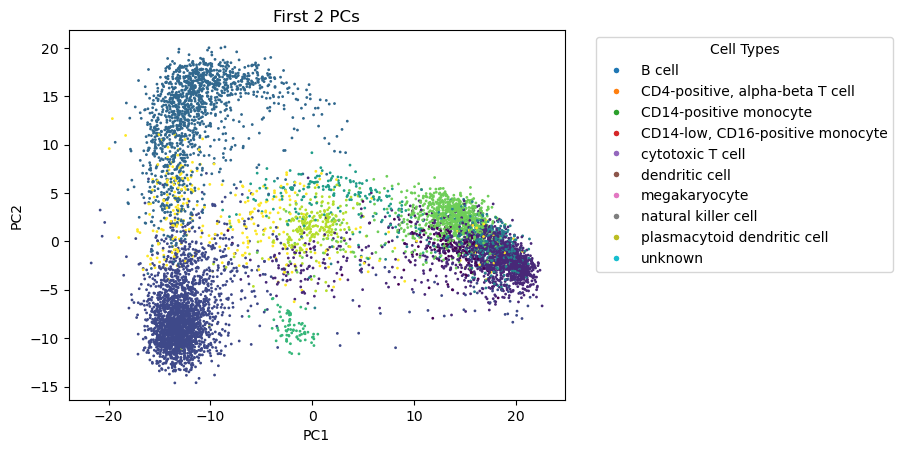

In [8]:
# Ensure 'cell_type' is a categorical dtype
cell_types = metadata['cell_type'].astype('category')

# Convert to category codes
cell_type_codes = cell_types.cat.codes

plt.scatter(x, y, c=cell_type_codes, s=1)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i), markersize=5) for i in range(len(cell_types.cat.categories))]
plt.legend(handles, cell_types.cat.categories, title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First 2 PCs')

plt.show()

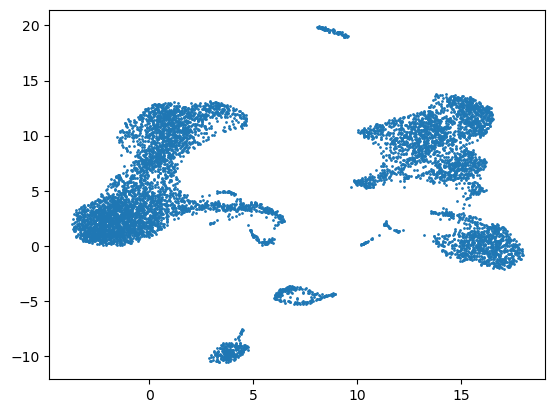

In [9]:
x = adata.obsm['X_umap'][:,0]
y = adata.obsm['X_umap'][:,1]
plt.scatter(x,y, s=1)

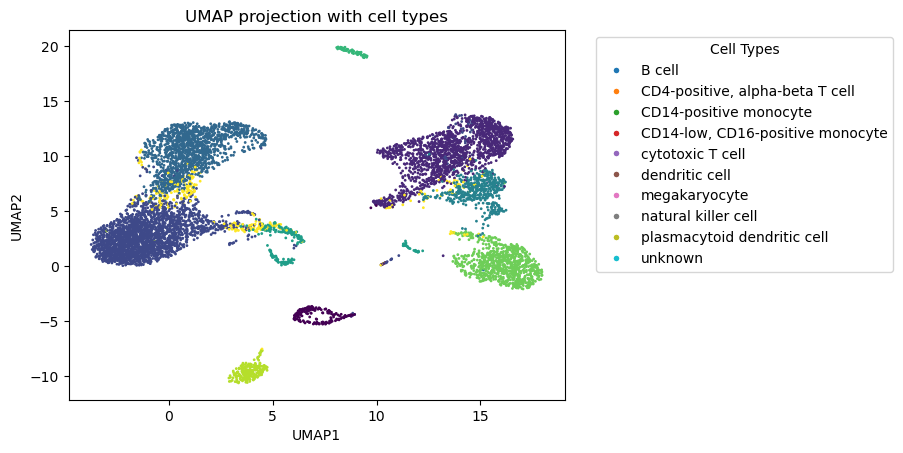

In [10]:
# Ensure 'cell_type' is a categorical dtype
cell_types = metadata['cell_type'].astype('category')

# Convert to category codes
cell_type_codes = cell_types.cat.codes

# Perform UMAP (assuming x and y are the UMAP coordinates)
plt.scatter(x, y, c=cell_type_codes, s=1)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i), markersize=5) for i in range(len(cell_types.cat.categories))]
plt.legend(handles, cell_types.cat.categories, title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP projection with cell types')

plt.show()

# NN Search

- Do KNN search $k=5$ for all cells
    - original space
    - PCA space
    - JL space
- Top hit recall

## Original

In [11]:
# just add data to knn object
knn_X = NearestNeighbors(n_neighbors=5)
knn_X.fit(df.values)
def knn_search(knn, query_row):
    distances, indices = knn.kneighbors([query_row])
    return distances, indices

knn_search(knn_X, df.iloc[0])
# 

(array([[  0.        , 180.47898865, 182.94607544, 183.10009766,
         183.45861816]]),
 array([[   0, 5946, 3052, 2859, 1443]]))

In [20]:
# sample size
s = 200
samples = df.sample(s,random_state=0)
samples.shape

(200, 29898)

In [23]:
start = time.time()
nn_original = {}
for i in samples.index:
    d, idx = knn_search(knn_X, samples.loc[i, :])
    nn_original[i] = {'dist': d.reshape(-1), 'idx': idx.reshape(-1)}
end = time.time()
print('Elapsed time: ', end-start)

Elapsed time:  316.45029282569885


In [24]:
outfile = 'nn_original.pth'
torch.save(nn_original, outfile)

In [28]:
loaded = torch.load(outfile)
print(list(loaded.items())[:5])
del loaded

[('ATTAAGAAAGGTACGA_Fluent-rep1', {'dist': array([5.39479652e-06, 1.81518738e+02, 1.82780640e+02, 1.82938095e+02,
       1.82963821e+02]), 'idx': array([2036, 5946, 2859, 3052, 5180])}), ('CAGCACCTCCGGACCT_Fluent-rep1', {'dist': array([6.60724936e-06, 2.17611588e+02, 2.19947556e+02, 2.20117661e+02,
       2.20265457e+02]), 'idx': array([ 572, 5946, 3385, 7734, 5180])}), ('AGGTATGAACATAATC_Fluent-rep1', {'dist': array([5.39479652e-06, 2.07575928e+02, 2.09223633e+02, 2.09241150e+02,
       2.09886429e+02]), 'idx': array([2570, 5946, 3052, 2859, 5180])}), ('CCCCACCGCCGACCAC_Fluent-rep1', {'dist': array([6.03156604e-06, 1.68533447e+02, 1.70592789e+02, 1.70973297e+02,
       1.71477798e+02]), 'idx': array([5776, 5946, 2859, 3052, 5180])}), ('CCAAACACCAATAACC_Fluent-rep1', {'dist': array([  0.        , 227.33882141, 229.20263672, 229.40010071,
       229.6394043 ]), 'idx': array([4737, 5946, 2859, 3052, 3385])})]


/tmp/ipykernel_1368205/1499570873.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(outfile)


In [29]:
nn_original[samples.index[0]]

{'dist': array([5.39479652e-06, 1.81518738e+02, 1.82780640e+02, 1.82938095e+02,
        1.82963821e+02]),
 'idx': array([2036, 5946, 2859, 3052, 5180])}

In [ ]:
# df_X_top5 = pd.DataFrame(nn_original).T
# df_X_top5['dist'] = df_X_top5['dist'].apply(lambda x: x[0])
# df_X_top5['idx'] = df_X_top5['idx'].apply(lambda x: x[0])
# df_X_top5.head(20)

,dist,idx
ATTAAGAAAGGTACGA_Fluent-rep1,"[5.394796517066425e-06, 181.51873779296875, 18...","[2036, 5946, 2859, 3052, 5180]"
CAGCACCTCCGGACCT_Fluent-rep1,"[6.607249360968126e-06, 217.61158752441406, 21...","[572, 5946, 3385, 7734, 5180]"
AGGTATGAACATAATC_Fluent-rep1,"[5.394796517066425e-06, 207.575927734375, 209....","[2570, 5946, 3052, 2859, 5180]"
CCCCACCGCCGACCAC_Fluent-rep1,"[6.031566044839565e-06, 168.533447265625, 170....","[5776, 5946, 2859, 3052, 5180]"
CCAAACACCAATAACC_Fluent-rep1,"[0.0, 227.3388214111328, 229.20263671875, 229....","[4737, 5946, 2859, 3052, 3385]"
AACGATAGAACACAGT_Fluent-rep1,"[5.394796517066425e-06, 196.52757263183594, 19...","[5032, 5946, 3052, 1216, 5180]"
AATAACTTAAGCAACT_Fluent-rep1,"[2.6973982585332124e-06, 159.98553466796875, 1...","[521, 5946, 3385, 3052, 5180]"
AGTTCCGACAGTCCCG_Fluent-rep1,"[0.0, 215.80174255371094, 217.78440856933594, ...","[533, 5946, 3052, 2859, 7734]"
ACGGCCCTAAACCCTA_Fluent-rep1,"[4.672031082009198e-06, 178.02708435058594, 17...","[541, 5946, 3052, 2859, 3385]"
CCCGCCAAATGTCCAC_Fluent-rep1,"[6.031566044839565e-06, 171.20077514648438, 17...","[1742, 5946, 2556, 3052, 1443]"


In [ ]:
# dists_expand = pd.DataFrame(df_X_top5['dist'].tolist(), index=df_X_top5.index)
# dists_expand.columns = ['dist1', 'dist2', 'dist3', 'dist4', 'dist5']
# df_X_top5_cln = df_X_top5.drop('dist', axis=1).join(dists_expand)

# idx_expand = pd.DataFrame(df_X_top5_cln['idx'].tolist(), index=df_X_top5_cln.index)
# idx_expand.columns = ['idx', 'idx', 'idx', 'idx', 'idx']
# df_X_top5_cln = df_X_top5_cln.drop('idx', axis=1).join(idx_expand)

# df_X_top5_cln.head(10)

,dist1,dist2,dist3,dist4,dist5,idx,idx,idx,idx,idx
ATTAAGAAAGGTACGA_Fluent-rep1,0.000005,181.518738,182.780640,182.938095,182.963821,2036,5946,2859,3052,5180
CAGCACCTCCGGACCT_Fluent-rep1,0.000007,217.611588,219.947556,220.117661,220.265457,572,5946,3385,7734,5180
AGGTATGAACATAATC_Fluent-rep1,0.000005,207.575928,209.223633,209.241150,209.886429,2570,5946,3052,2859,5180
CCCCACCGCCGACCAC_Fluent-rep1,0.000006,168.533447,170.592789,170.973297,171.477798,5776,5946,2859,3052,5180
CCAAACACCAATAACC_Fluent-rep1,0.000000,227.338821,229.202637,229.400101,229.639404,4737,5946,2859,3052,3385
AACGATAGAACACAGT_Fluent-rep1,0.000005,196.527573,198.485245,198.661835,198.662430,5032,5946,3052,1216,5180
AATAACTTAAGCAACT_Fluent-rep1,0.000003,159.985535,161.435486,161.787811,162.271484,521,5946,3385,3052,5180
AGTTCCGACAGTCCCG_Fluent-rep1,0.000000,215.801743,217.784409,218.696487,218.706818,533,5946,3052,2859,7734
ACGGCCCTAAACCCTA_Fluent-rep1,0.000005,178.027084,179.778549,179.884094,179.992905,541,5946,3052,2859,3385
CCCGCCAAATGTCCAC_Fluent-rep1,0.000006,171.200775,174.223602,174.678452,174.902847,1742,5946,2556,3052,1443


In [ ]:
# df_X_top5_cln.shape

(200, 10)

In [ ]:
# df_X_top5_cln.to_csv('eval/nn_X.tsv', sep='\t', index=True)

In [43]:
df.shape

(7750, 29898)

### PCA

In [33]:
# do nn search over pca
pca = PCA(n_components=3537)
pca.fit(df.values)
X_pca = pca.transform(df.values)
X_pca = pd.DataFrame(X_pca, index=df.index, columns=[f'PC{i}' for i in range(1,3538)])
print(X_pca.shape)
X_pca.head()

(7750, 3537)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC3528,PC3529,PC3530,PC3531,PC3532,PC3533,PC3534,PC3535,PC3536,PC3537
AGGCATAGCAGCATTA_Fluent-rep1,19.477104,5.682237,4.736247,-3.793215,17.012316,-6.037767,-0.322049,0.028445,-0.888267,0.481528,...,0.074729,-1.667771,-2.097032,-0.923450,-0.984132,0.044444,-1.947943,-0.386849,0.784832,2.172138
AACTAGCACAAACAAC_Fluent-rep1,-18.944384,12.058154,3.604785,-1.083457,0.934817,8.728113,2.143472,-3.447311,0.821329,1.560833,...,-2.323333,-1.468183,0.129240,-2.244448,0.840983,-0.484452,-3.358890,-0.767286,-3.390129,-0.773466
AAAAAGCGCCCGATTA_Fluent-rep1,23.001728,-0.682060,-1.636601,-2.091014,-7.320517,2.036269,0.771935,-0.475741,-0.819019,-3.003517,...,1.539105,-1.517079,1.650617,-0.442471,-0.448821,-0.107460,-1.206702,1.713671,-2.528907,1.386923
ATGTATAGAAAGCAGA_Fluent-rep1,-1.943157,-57.014809,95.967255,13.733642,-5.007924,4.104903,-0.726695,4.160145,-1.960216,0.382937,...,-0.631418,-2.425409,0.845153,-0.767236,-0.677609,1.550331,0.942701,-3.945027,0.909389,-0.997065
CCCCATGGACACAAGT_Fluent-rep1,-17.621546,-6.154138,-2.561608,0.749829,2.030993,-1.004031,0.455973,4.960244,1.287000,-2.217367,...,-1.403123,0.384255,-1.380910,0.128842,0.142290,0.506899,2.466295,-0.861639,2.152564,-0.802159


In [34]:
X_pca.to_csv('X_pca.tsv', sep='\t', index=True)

Text(0, 0.5, 'Cumulative explained variance')

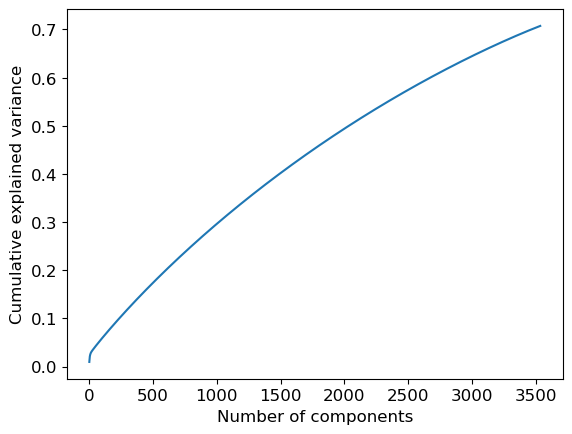

In [45]:
# plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

explained variance is not great for ~3.5k PCs

In [36]:
# do nn search over pca
knn_pca = NearestNeighbors(n_neighbors=5)
knn_pca.fit(X_pca.values)

NearestNeighbors()

In [38]:
# start = time.time()
# nn_pca = {}
# for i in range(s):
#     d, idx = knn_search(knn_pca, X_pca.iloc[i])
#     nn_pca[i] = {'dist': d, 'idx': idx}
# end = time.time()
# print('Elapsed time: ', end-start)

start = time.time()
nn_pca = {}
for i in samples.index:
    d, idx = knn_search(knn_pca, X_pca.loc[i, :])
    nn_pca[i] = {'dist': d.reshape(-1), 'idx': idx.reshape(-1)}
end = time.time()
print('Elapsed time: ', end-start)

Elapsed time:  27.23065209388733


In [39]:
outfile='nn_pca.pth'
torch.save(nn_pca, outfile)

In [42]:
# evaluate nn search by comparing encoding hits to pca hits
# loop over dicts and compare indices
def compare_hits(nn, nn_pca, k=5):
    max_recall = len(nn.items()) * k
    recall_at_k = 0
    for i in nn.keys():
        enc = set(nn[i]['idx'])
        pca = set(nn_pca[i]['idx'])
        print(enc,'\n',pca)
        inter = enc & pca
        recall_at_k += len(inter)
        print('recall at k: ', len(inter))
    return recall_at_k / max_recall
recall = compare_hits(nn_original, nn_pca)
print(recall)

{np.int64(2859), np.int64(3052), np.int64(2036), np.int64(5946), np.int64(5180)} 
 {np.int64(584), np.int64(7313), np.int64(2036), np.int64(2553), np.int64(3738)}
recall at k:  1
{np.int64(5180), np.int64(7734), np.int64(3385), np.int64(5946), np.int64(572)} 
 {np.int64(3385), np.int64(2859), np.int64(7734), np.int64(2553), np.int64(572)}
recall at k:  3
{np.int64(2570), np.int64(2859), np.int64(3052), np.int64(5946), np.int64(5180)} 
 {np.int64(1216), np.int64(2570), np.int64(2859), np.int64(5549), np.int64(7734)}
recall at k:  2
{np.int64(2859), np.int64(3052), np.int64(5776), np.int64(5946), np.int64(5180)} 
 {np.int64(2859), np.int64(5776), np.int64(7313), np.int64(2553), np.int64(7102)}
recall at k:  2
{np.int64(4737), np.int64(2859), np.int64(3052), np.int64(3385), np.int64(5946)} 
 {np.int64(4737), np.int64(2859), np.int64(5549), np.int64(3385), np.int64(7102)}
recall at k:  3
{np.int64(1216), np.int64(5032), np.int64(3052), np.int64(5946), np.int64(5180)} 
 {np.int64(1216), np.

/data/jake/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


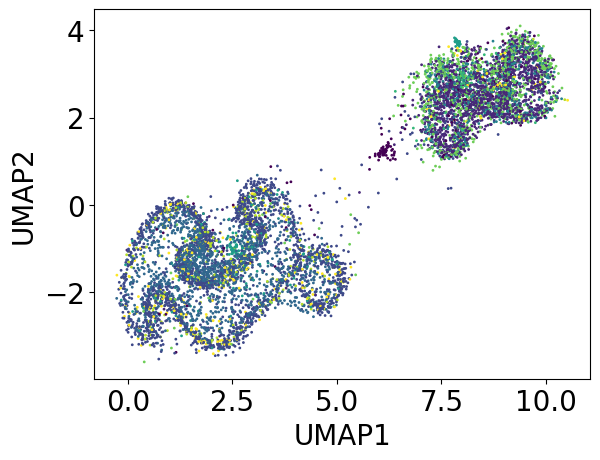

In [62]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
# Fit and transform the data
umap_PCA = reducer.fit_transform(X_pca)

# Ensure 'cell_type' is a categorical dtype
cell_types = metadata['cell_type'].astype('category')

# Convert to category codes
cell_type_codes = cell_types.cat.codes

plt.scatter(umap_PCA[:,0], umap_PCA[:,1], c=cell_type_codes, s=1)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

### JL

In [48]:
m = df.shape[0]
eps = 0.15
# compute the number of components needed for a given epsilon
k = johnson_lindenstrauss_min_dim(m,eps=eps)

In [50]:
# do transform
jl = GaussianRandomProjection(n_components=k, random_state=0)
X_jl = jl.fit_transform(df.values)
X_jl = pd.DataFrame(X_jl, index=df.index, columns=[f'jl_{i}' for i in range(1,k+1)])
print(X_jl.shape)

(7750, 3537)


In [51]:
X_jl.to_csv('X_jl.tsv', sep='\t',index=True)

In [52]:
# do nn search over jl
knn_jl = NearestNeighbors(n_neighbors=5)
knn_jl.fit(X_jl.values)

NearestNeighbors()

In [53]:
start = time.time()
nn_jl = {}
for i in samples.index:
    d, idx = knn_search(knn_jl, X_jl.loc[i, :])
    nn_jl[i] = {'dist': d.reshape(-1), 'idx': idx.reshape(-1)}
end = time.time()
print('Elapsed time: ', end-start)

Elapsed time:  28.730685472488403


In [54]:
recall = compare_hits(nn_original, nn_jl)
print(recall)

{np.int64(2859), np.int64(3052), np.int64(2036), np.int64(5946), np.int64(5180)} 
 {np.int64(3657), np.int64(2859), np.int64(3052), np.int64(2036), np.int64(5946)}
recall at k:  4
{np.int64(5180), np.int64(7734), np.int64(3385), np.int64(5946), np.int64(572)} 
 {np.int64(3052), np.int64(7734), np.int64(3385), np.int64(5946), np.int64(572)}
recall at k:  4
{np.int64(2570), np.int64(2859), np.int64(3052), np.int64(5946), np.int64(5180)} 
 {np.int64(2570), np.int64(5549), np.int64(7734), np.int64(5946), np.int64(5180)}
recall at k:  3
{np.int64(2859), np.int64(3052), np.int64(5776), np.int64(5946), np.int64(5180)} 
 {np.int64(3657), np.int64(2859), np.int64(3052), np.int64(5776), np.int64(5946)}
recall at k:  4
{np.int64(4737), np.int64(2859), np.int64(3052), np.int64(3385), np.int64(5946)} 
 {np.int64(4737), np.int64(3052), np.int64(7734), np.int64(3928), np.int64(5946)}
recall at k:  3
{np.int64(1216), np.int64(5032), np.int64(3052), np.int64(5946), np.int64(5180)} 
 {np.int64(1216), np

In [55]:
outfile = 'nn_jl.pth'
torch.save(nn_jl, outfile)

/data/jake/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


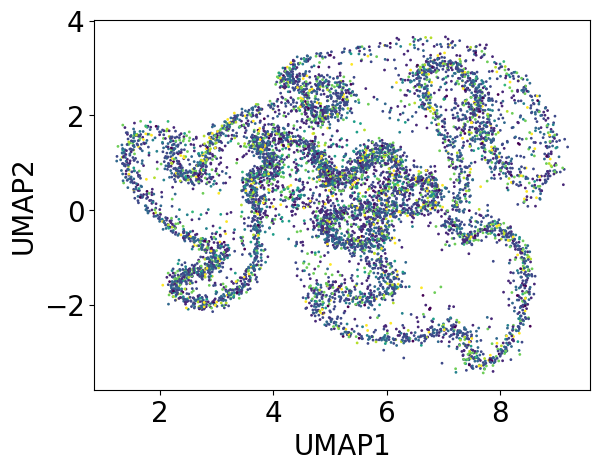

In [63]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
# Fit and transform the data
umap_jl = reducer.fit_transform(X_jl)

# Ensure 'cell_type' is a categorical dtype
cell_types = metadata['cell_type'].astype('category')

# Convert to category codes
cell_type_codes = cell_types.cat.codes

plt.scatter(umap_jl[:,0], umap_jl[:,1], c=cell_type_codes, s=1)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

(7750, 2)


Text(0, 0.5, 't-SNE2')

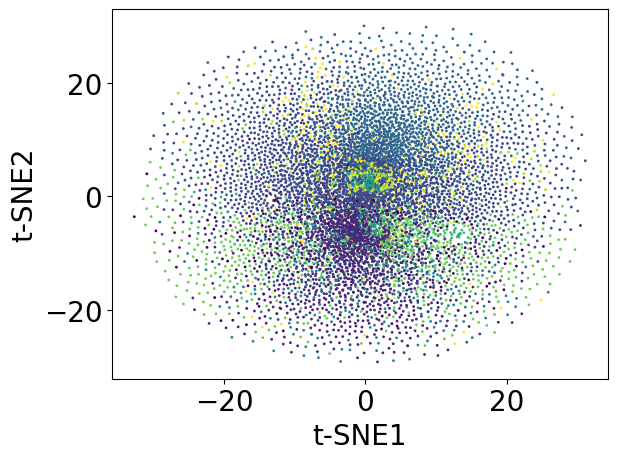

In [64]:
# do tsne plot
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_jl.values)
X_tsne = pd.DataFrame(X_tsne, index=df.index, columns=['tsne1', 'tsne2'])
print(X_tsne.shape)
# plot
plt.scatter(X_tsne['tsne1'], X_tsne['tsne2'], c=cell_type_codes, s=1)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')


## SNN

### Data

In [22]:
X_test = samples
X_train = df.drop(X_test.index)
print(df.shape)
print(X_train.shape)
print(X_test.shape)

(7750, 29898)
(7650, 29898)
(100, 29898)


In [23]:
# further subset training data
# to simplify training
X_train = X_train.sample(1000, random_state=0)
X_train.shape

(1000, 29898)

In [ ]:
# L2
# # compute pairwise distances of training samples
# pw_dists = pd.DataFrame(columns = ['idx1', 'idx2', 'dist'])
# for i, j in itertools.combinations(X_train.index, 2):
#     dist = np.linalg.norm(X_train.loc[i] - X_train.loc[j])
#     row = pd.DataFrame({'idx1': i, 'idx2': j, 'dist': dist}, index=[0])
#     pw_dists = pd.concat([pw_dists, row])
# print(pw_dists.shape)
# pw_dists.to_csv('data/pw_dists-train.tsv', index=False,sep='\t')
# pw_dists.head()

/tmp/ipykernel_1113673/3418156496.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pw_dists = pd.concat([pw_dists, row])


(499500, 3)


,idx1,idx2,dist
0,ACTAAACCATAACATT_Fluent-rep1,CATCATTCAGGTCCAA_Fluent-rep1,233.788040
0,ACTAAACCATAACATT_Fluent-rep1,ATCCCCGCCACCAAGA_Fluent-rep1,252.568710
0,ACTAAACCATAACATT_Fluent-rep1,CCATACCCCATAACAA_Fluent-rep1,254.370712
0,ACTAAACCATAACATT_Fluent-rep1,ATGTACTTCCAAATAG_Fluent-rep1,248.228760
0,ACTAAACCATAACATT_Fluent-rep1,CATTCCTTATATCCGA_Fluent-rep1,232.979767


In [123]:
# # cosine similarity
# # compute pairwise cosine similarity of training samples
# pw_cosine_train = pd.DataFrame(columns = ['idx1', 'idx2', 'sim'])
# for i, j in itertools.combinations(X_train.index, 2):
#     norm_i = np.linalg.norm(X_train.loc[i])
#     norm_j = np.linalg.norm(X_train.loc[j])
#     sim = np.dot(X_train.loc[i], X_train.loc[j]) / (norm_i * norm_j)
#     row = pd.DataFrame({'idx1': i, 'idx2': j, 'sim': sim}, index=[0])
#     pw_cosine_train = pd.concat([pw_cosine_train, row])
# print(pw_cosine_train.shape)
# pw_cosine_train.to_csv('data/pw-cosine-train.tsv', index=False,sep='\t')

/tmp/ipykernel_1131049/85685662.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pw_cosine_train = pd.concat([pw_cosine_train, row])


(499500, 3)


In [ ]:
# # cosine similarity
# # compute pairwise cosine similarity of test samples
# pw_cosine_test = pd.DataFrame(columns = ['idx1', 'idx2', 'sim'])
# for i, j in itertools.combinations(X_test.index, 2):
#     norm_i = np.linalg.norm(X_test.loc[i])
#     norm_j = np.linalg.norm(X_test.loc[j])
#     sim = np.dot(X_test.loc[i], X_test.loc[j]) / (norm_i * norm_j)
#     row = pd.DataFrame({'idx1': i, 'idx2': j, 'sim': sim}, index=[0])
#     pw_cosine_test = pd.concat([pw_cosine_test, row])
# print(pw_cosine_test.shape)
# pw_cosine_test.to_csv('data/pw-cosine-test.tsv', index=False,sep='\t')

/tmp/ipykernel_1131049/2408793380.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pw_cosine_test = pd.concat([pw_cosine_test, row])


(4950, 3)


In [ ]:
# # compute pairwise distances of test samples
# pw_dists_test = pd.DataFrame(columns = ['idx1', 'idx2', 'dist'])
# for i, j in itertools.combinations(X_test.index, 2):
#     dist = np.linalg.norm(X_test.loc[i] - X_test.loc[j])
#     row = pd.DataFrame({'idx1': i, 'idx2': j, 'dist': dist}, index=[0])
#     pw_dists_test = pd.concat([pw_dists_test, row])
# print(pw_dists_test.shape)
# pw_dists_test.to_csv('data/pw_dists-test.tsv', index=False,sep='\t')
# pw_dists_test.head()

/tmp/ipykernel_1131049/941368947.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pw_dists_test = pd.concat([pw_dists_test, row])


(4950, 3)


,idx1,idx2,dist
0,ATTAAGAAAGGTACGA_Fluent-rep1,CAGCACCTCCGGACCT_Fluent-rep1,250.534332
0,ATTAAGAAAGGTACGA_Fluent-rep1,AGGTATGAACATAATC_Fluent-rep1,239.837082
0,ATTAAGAAAGGTACGA_Fluent-rep1,CCCCACCGCCGACCAC_Fluent-rep1,207.626556
0,ATTAAGAAAGGTACGA_Fluent-rep1,CCAAACACCAATAACC_Fluent-rep1,258.140045
0,ATTAAGAAAGGTACGA_Fluent-rep1,AACGATAGAACACAGT_Fluent-rep1,230.695129


In [158]:
train_tensors = {}
for i in X_train.index:
    train_tensors[i] = torch.tensor(X_train.loc[i].values, dtype=torch.float32)
print(list(train_tensors.items())[0:1])
print(list(train_tensors.values())[0].shape)

[('ACTAAACCATAACATT_Fluent-rep1', tensor([-0.0315, -0.1255, -0.0313,  ..., -0.0186, -0.1657, -0.0419]))]
torch.Size([29898])


In [162]:
class SiameseDataset(Dataset):
    def __init__(self, tensors, targets):
        self.tensors = tensors
        self.targets = targets
        self.n_samples = targets.shape[0]
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # just loop over df
        row_target = self.targets.iloc[idx, :]
        target = torch.tensor(row_target.iloc[2], dtype=torch.float32)
        # lookup tensor pair
        x1 = self.tensors[row_target['idx1']]
        x2 = self.tensors[row_target['idx2']]
        return x1, x2, target
dataset = SiameseDataset(train_tensors, pw_cosine_train)
# dataset = SiameseDataset(train_tensors, pw_dists)
print(dataset.__len__())

499500


In [161]:
# # test
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# x,y,z = next(iter(dataloader))
# print(x,y,z)

In [163]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### Network

In [164]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
    def forward_one(self, x):
        # compute embedding
        return self.fc(x)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

### Train

In [169]:
input_dim = len(list(train_tensors.values())[0])
embedding_dim = 3000
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1

29898 3000


In [170]:
torch.set_num_threads(64)
dirlog = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=f"logs/{dirlog}")
early_stop_thresh = 1e-8
early_stopping_batch = 500
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    batch = 0
    for i, data in enumerate(dataloader):
        # reset grad    
        optimizer.zero_grad()
        x1, x2, target = data
        x1, x2, target = x1.to(device), x2.to(device), target.to(device)
        e1, e2 = model(x1, x2)
        distance = F.pairwise_distance(e1, e2)
        loss = mse_loss(target, distance)
        loss.backward()
        optimizer.step()
        lss = loss.item()
        l.append(lss)
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
        # if lss < early_stop_thresh:
        #     break
        batch += 1
        if batch >= early_stopping_batch:
            break
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()


Epoch 1, batch 1, loss: 30.88550567626953
Epoch 1, batch 2, loss: 2.9147276878356934
Epoch 1, batch 3, loss: 0.7412208914756775
Epoch 1, batch 4, loss: 0.2735465466976166
Epoch 1, batch 5, loss: 0.3097640872001648
Epoch 1, batch 6, loss: 0.6736777424812317
Epoch 1, batch 7, loss: 0.02922302670776844
Epoch 1, batch 8, loss: 0.07526650279760361
Epoch 1, batch 9, loss: 0.0870884507894516
Epoch 1, batch 10, loss: 0.0022297033574432135
Epoch 1, batch 11, loss: 0.2026006132364273
Epoch 1, batch 12, loss: 0.0001920903887366876
Epoch 1, batch 13, loss: 0.006652101408690214
Epoch 1, batch 14, loss: 0.00036663791979663074
Epoch 1, batch 15, loss: 0.0001450265699531883
Epoch 1, batch 16, loss: 0.00014124457084108144
Epoch 1, batch 17, loss: 0.00019296733080409467
Epoch 1, batch 18, loss: 0.0001622542622499168
Epoch 1, batch 19, loss: 0.00022462918423116207
Epoch 1, batch 20, loss: 0.00014871745952405035
Epoch 1, batch 21, loss: 0.00015366253501269966
Epoch 1, batch 22, loss: 0.0001213195937452837

In [171]:
# torch.save(model.state_dict(), 'siamese-trained-l2.pth')
torch.save(model.state_dict(), 'siamese-trained-cosine.pth')

### Eval

In [182]:
model = SiameseNetwork(input_dim, embedding_dim)
# model.load_state_dict(torch.load("siamese-trained-l2.pth"))
model.load_state_dict(torch.load("siamese-trained-cosine.pth"))
model.to(device)
model.eval()


/tmp/ipykernel_1131049/886817490.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("siamese-trained-cosine.pth"))


SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=29898, out_features=3000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3000, out_features=3000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3000, out_features=3000, bias=True)
  )
)

In [183]:
# print(pw_dists_test.shape)
# pw_dists_test.head()
pw_cosine_test.head()

,idx1,idx2,sim
0,ATTAAGAAAGGTACGA_Fluent-rep1,CAGCACCTCCGGACCT_Fluent-rep1,0.003972
0,ATTAAGAAAGGTACGA_Fluent-rep1,AGGTATGAACATAATC_Fluent-rep1,0.013942
0,ATTAAGAAAGGTACGA_Fluent-rep1,CCCCACCGCCGACCAC_Fluent-rep1,0.024545
0,ATTAAGAAAGGTACGA_Fluent-rep1,CCAAACACCAATAACC_Fluent-rep1,0.003028
0,ATTAAGAAAGGTACGA_Fluent-rep1,AACGATAGAACACAGT_Fluent-rep1,0.013663


In [184]:
test_tensors = {}
for i in X_test.index:
    test_tensors[i] = torch.tensor(X_test.loc[i].values, dtype=torch.float32)
print(list(test_tensors.items())[0:1])
print(list(test_tensors.values())[0].shape)


[('ATTAAGAAAGGTACGA_Fluent-rep1', tensor([-0.0315, -0.1255, -0.0313,  ..., -0.0186, -0.1657, -0.0419]))]
torch.Size([29898])


In [186]:
# inference on test pairs
ys = []
y_preds = []
model.eval()
for i, row in pw_cosine_test.iterrows():
    i1 = row['idx1']
    i2 = row['idx2']
    x1 = test_tensors[i1].to(device)
    x2 = test_tensors[i2].to(device)
    e1, e2 = model(x1, x2)
    print(e1,e2)
    # compute cossim
    embedding_distance = F.cosine_similarity(e1, e2, dim=0)
    # embedding_distance = torch.dot(e1, e2) / (e1_norm * e2_norm)
    # embedding_distance = F.pairwise_distance(e1, e2)
    y = row.iloc[2]
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {i1}, {i2}, target: {y}, sim: {y_pred}")


tensor([ 0.0123, -0.0092,  0.0108,  ..., -0.0127,  0.0008,  0.0066],
       grad_fn=<ViewBackward0>) tensor([ 0.0123, -0.0092,  0.0108,  ..., -0.0127,  0.0008,  0.0066],
       grad_fn=<ViewBackward0>)
Pair: ATTAAGAAAGGTACGA_Fluent-rep1, CAGCACCTCCGGACCT_Fluent-rep1, target: 0.003971809986978769, sim: 0.9999999403953552
tensor([ 0.0123, -0.0092,  0.0108,  ..., -0.0127,  0.0008,  0.0066],
       grad_fn=<ViewBackward0>) tensor([ 0.0123, -0.0092,  0.0108,  ..., -0.0127,  0.0008,  0.0066],
       grad_fn=<ViewBackward0>)
Pair: ATTAAGAAAGGTACGA_Fluent-rep1, AGGTATGAACATAATC_Fluent-rep1, target: 0.013941638171672821, sim: 0.9999999403953552
tensor([ 0.0123, -0.0092,  0.0108,  ..., -0.0127,  0.0008,  0.0066],
       grad_fn=<ViewBackward0>) tensor([ 0.0123, -0.0092,  0.0108,  ..., -0.0127,  0.0008,  0.0066],
       grad_fn=<ViewBackward0>)
Pair: ATTAAGAAAGGTACGA_Fluent-rep1, CCCCACCGCCGACCAC_Fluent-rep1, target: 0.024545419961214066, sim: 0.9999999403953552
tensor([ 0.0123, -0.0092,  0.0108,

KeyboardInterrupt: 

# Old

In [74]:
X = df.values
print(X.shape)

(7750, 29898)


In [ ]:
# split into train and test
# track the indices of the train and test sets
# from sklearn.model_selection import train_test_split
# X_train, X_test = train_test_split(X, test_size=0.25, random_state=0)
indices_train, indices_test = train_test_split(df.index, test_size=0.2, random_state=0)
X_train = df.loc[indices_train, :]
X_test = df.loc[indices_test, :]
print(X_train.shape, X_test.shape)

(6200, 29898) (1550, 29898)


In [90]:
# ground truth pairwise distances of the test set
# use itertools to generate all pairs of indices in the test set
test_pairs = list(itertools.combinations(range(X_test.shape[0]), 2))
print(len(test_pairs))
test_pairs[:5]

1200475


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

### Ground truth distances

In [99]:
# calculate the pairwise distances of the test set
# do cosine similarity for all test pairs
def cosine_similarity(X, Y):
    return np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y))
d1_y = np.array([cosine_similarity(X_test[i], X_test[j]) for i, j in test_pairs])
d1_y.shape

(1200475,)

In [100]:
# to dataframe
d1_y_df = pd.DataFrame(d1_y, columns=['cosine_similarity'])
d1_y_df['pair'] = test_pairs
d1_y_df.head()

,cosine_similarity,pair
0,0.003972,"(0, 1)"
1,0.013942,"(0, 2)"
2,0.024545,"(0, 3)"
3,0.003028,"(0, 4)"
4,0.013663,"(0, 5)"


### PCA

In [ ]:
# do pca on train
from sklearn.decomposition import PCA
pca = PCA(n_components=200, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
# get rotation matrix
W = pca.components_
print(W.shape)

In [95]:
X_test_pca = X_test @ W.T
X_test_pca

array([[-20.842833  ,  18.295961  ,   9.77007   , ...,  -1.6625096 ,
          1.0859948 ,   0.10771837],
       [-15.3842535 ,  -4.200685  ,  -3.3920078 , ...,   0.12203413,
         -0.05083152,  -0.6059364 ],
       [-17.008232  ,  -8.167656  ,  -7.7333694 , ...,   0.4366512 ,
          0.3765722 ,   0.05755835],
       ...,
       [-14.248724  ,  15.994976  ,   9.522601  , ...,   0.22746985,
         -0.2156096 ,  -0.45839244],
       [ -9.032824  ,  16.677439  ,  11.005118  , ...,  -0.9034171 ,
          0.49099588,  -0.24031992],
       [-12.93642   , -12.376646  ,  -7.772749  , ...,  -3.0133333 ,
          2.4317427 ,  -0.5426255 ]], dtype=float32)

### Pairwise distance loss

In [44]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X)

NearestNeighbors(metric='cosine')

In [48]:
query_idx = 0
distances, indices = knn.kneighbors([X[query_idx]])
print(distances,df.index[indices[0]])

[[1.1324883e-06 8.9482927e-01 9.1477811e-01 9.1766834e-01 9.2200655e-01]] Index(['AGGCATAGCAGCATTA_Fluent-rep1', 'CCCCCCCCATTAATTA_Fluent-rep1',
       'CATCAAGGCAACAGTG_Fluent-rep1', 'CAATAGAGATATAGCG_Fluent-rep1',
       'CCGCCCCAAATAAGCA_Fluent-rep1'],
      dtype='object')


In [30]:
# compute k for johnson lindestrauss lemma
# given sample size of 7750
# and epsilon of 0.1
eps = 0.1
k = 4 * np.log(7750) / (eps**2 / 2 -eps**3 / 3)
print(k)

7676.098390583478
